## Start

In [24]:
import math
import pickle 
import joblib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier
import lightgbm as lgb
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import roc_auc_score, confusion_matrix, recall_score, precision_score
from sklearn.inspection import PartialDependenceDisplay




In [25]:
# datasource https://archive.ics.uci.edu/ml/machine-learning-databases/00222/
path = '/Users/kseniia/OneDrive/MSDS/Thesis/'
add = 'data/bank-marketing/bank-additional/'
data = pd.read_csv(path+add+'bank-additional.csv', sep=';')
print(data.shape)

(4119, 21)


## Briefly explore data 

bank client data:
1. age (numeric)
2. job : type of job (categorical: ‘admin.’,’blue-collar’,’entrepreneur’,’housemaid’,’management’,’retired’,’self-employed’,’services’,’student’,’technician’,’unemployed’,’unknown’)
3. marital : marital status (categorical: ‘divorced’,’married’,’single’,’unknown’; note: ‘divorced’ means divorced or widowed)
4. education (categorical: ‘basic.4y’,’basic.6y’,’basic.9y’,’high.school’,’illiterate’,’professional.course’,’university.degree’,’unknown’)
5. default: has credit in default? (categorical: ‘no’,’yes’,’unknown’)
6. housing: has housing loan? (categorical: ‘no’,’yes’,’unknown’)
7. loan: has personal loan? (categorical: ‘no’,’yes’,’unknown’)

Related with the last contact of the current campaign:
8. contact: contact communication type (categorical: ‘cellular’,’telephone’)
9. month: last contact month of year (categorical: ‘jan’, ‘feb’, ‘mar’, …, ‘nov’, ‘dec’)
10. day_of_week: last contact day of the week (categorical: ‘mon’,’tue’,’wed’,’thu’,’fri’)
11. duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y=’no’). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

other attributes:
12. campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13. pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14. previous: number of contacts performed before this campaign and for this client (numeric)
15. poutcome: outcome of the previous marketing campaign (categorical: ‘failure’,’nonexistent’,’success’)

social and economic context attributes
16. emp.var.rate: employment variation rate — quarterly indicator (numeric)
17. cons.price.idx: consumer price index — monthly indicator (numeric)
18. cons.conf.idx: consumer confidence index — monthly indicator (numeric)
19. euribor3m: euribor 3 month rate — daily indicator (numeric)
20. nr.employed: number of employees — quarterly indicator (numeric)

In [26]:
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,30,blue-collar,married,basic.9y,no,yes,no,cellular,may,fri,...,2,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no
1,39,services,single,high.school,no,no,no,telephone,may,fri,...,4,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
2,25,services,married,high.school,no,yes,no,telephone,jun,wed,...,1,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,no
3,38,services,married,basic.9y,no,unknown,unknown,telephone,jun,fri,...,3,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,no
4,47,admin.,married,university.degree,no,yes,no,cellular,nov,mon,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,no


In [27]:
data['y'].value_counts()/data.shape[0]

no     0.890507
yes    0.109493
Name: y, dtype: float64

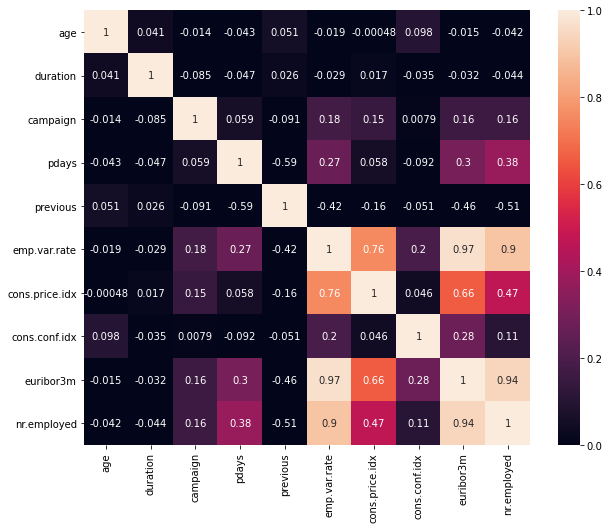

In [28]:
plt.figure(figsize=(10,8))
sns.heatmap(data.corr(), vmin=0, annot=True);

## Preprocess and create pipeline

In [29]:
data.replace({'no':0, 'yes':1}, inplace=True)
data.replace({999: -1}, inplace=True)
data.default.replace({'unknown': 1}, inplace=True)

weekday_dict = {'mon': 1, 'tue': 2, 'wed': 3, 'thu': 4,  'fri': 5, 'sat': 6, 'sun': 7}
month_dict = {'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4,  'may': 5, 'jun': 6, 'jul': 7,
              'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11,  'dec': 12}

# data['month'] = data.month.replace(month_dict).astype(float)
# data['day_of_week'] = data.day_of_week.replace(weekday_dict).astype(float)


# def cyclic_transformation(column):
#     max_value = column.max()
#     sin_values = np.sin(2*math.pi*column/max_value)
#     cos_values = np.cos(2*math.pi*column/max_value)
#     return sin_values, cos_values

In [30]:
# data['month_sin'], data['month_cos'] = cyclic_transformation(data.month)
# data['weekday_sin'], data['weekday_cos'] = cyclic_transformation(data.day_of_week)
# data.drop(columns=['month','day_of_week'], inplace=True)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=['y', 'duration']), 
                                                    data['y'], test_size=0.2, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True)

In [32]:
X_train.shape, X_val.shape, X_test.shape

((2636, 19), (659, 19), (824, 19))

In [33]:
X_train.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
707,29,student,single,university.degree,0,1,0,cellular,jul,thu,1,-1,0,nonexistent,1.4,93.918,-42.7,4.963,5228.1
1068,38,admin.,married,high.school,0,1,0,telephone,jun,mon,1,-1,0,nonexistent,1.4,94.465,-41.8,4.865,5228.1
1144,59,admin.,married,high.school,0,0,0,telephone,jun,mon,4,-1,0,nonexistent,1.4,94.465,-41.8,4.960,5228.1
474,44,blue-collar,married,basic.4y,0,unknown,unknown,telephone,jun,thu,3,-1,0,nonexistent,1.4,94.465,-41.8,4.866,5228.1
3896,42,technician,married,professional.course,0,1,0,cellular,jul,fri,2,-1,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1


In [34]:
ord_edu = ['illiterate', 'basic.4y', 'basic.6y', 'basic.9y', 'unknown', 'high.school', 
           'professional.course', 'university.degree']

Define groups of columns

In [35]:
# include current campaign data
categorical_cols = ['job', 'marital', 'education', 'housing', 'loan',
                   'contact', 'poutcome', 'month','day_of_week']
num_cols = ['pdays', 'emp.var.rate', 'cons.price.idx',
            'cons.conf.idx', 'euribor3m', 'nr.employed']

other_cols = ['default', 'month_sin', 'month_cos', 'weekday_sin', 'weekday_cos']
log_cols = ['age', 'campaign', 'previous']

# exclude current campaign data
current_campaign_cols = ['contact', 'campaign']
categorical_cols_excl = ['job', 'marital', 'education', 'housing', 'loan', 'poutcome', 'month','day_of_week']
num_cols_excl = ['pdays', 'emp.var.rate', 'cons.price.idx',
                 'cons.conf.idx', 'euribor3m', 'nr.employed']
other_cols_excl = ['default']
log_cols_excl = ['age', 'previous']

In [36]:
def to_str(x):
    return pd.DataFrame(x).astype(str)

logarithm_transformer = FunctionTransformer(np.log1p, validate=True)

cat_pipe = make_pipeline(FunctionTransformer(to_str), OneHotEncoder(handle_unknown='ignore'))
log_pipe = make_pipeline(logarithm_transformer, MinMaxScaler())
# time_pipe = make_pipeline(FunctionTransformer(cyclic_transformation))

Define 2 pipelines

In [37]:
column_transformer = ColumnTransformer([
 ('ohe', cat_pipe, categorical_cols),
 ('scale', MinMaxScaler(), num_cols),
 ('log', log_pipe, log_cols),
],
remainder='passthrough', verbose=0
)

column_transformer_excl = ColumnTransformer([
 ('ohe', cat_pipe, categorical_cols_excl),
 ('scale', MinMaxScaler(), num_cols_excl),
 ('log', log_pipe, log_cols_excl),
 ('dropper', 'drop', current_campaign_cols),
],
remainder='passthrough', verbose=0
)

## Train models

### Define and train full model

In [38]:
lgbm_params = {
                'lgbmclassifier__learning_rate': [0.01,0.03,0.05,0.1,0.15,0.2],
                'lgbmclassifier__max_depth': [6,8,10,12,16,20,30],
                'lgbmclassifier__num_leaves': [8,16,32,64,96,144],
                'lgbmclassifier__feature_fraction': [0.2, 0.4, 0.8, 1],
                'lgbmclassifier__subsample': [0.2, 0.4, 0.8, 1],
                'lgbmclassifier__is_unbalance': [True,False],
              }

In [19]:
grid_pipe_lgbm = GridSearchCV(make_pipeline(column_transformer, LGBMClassifier()), 
                             lgbm_params, cv=5, scoring='roc_auc', verbose=2, n_jobs=5)
grid_pipe_lgbm.fit(X_train, y_train)

Fitting 5 folds for each of 8064 candidates, totalling 40320 fits
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('functiontransformer',
                                                                                          FunctionTransformer(func=<function to_str at 0x7f89b0e4b040>)),
                                                                                         ('onehotencoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['job',
                                                                          'marital',
                                                                          'education

In [20]:
print(
      roc_auc_score(y_train, grid_pipe_lgbm.predict(X_train)), 
      roc_auc_score(y_val, grid_pipe_lgbm.predict(X_val)),
      roc_auc_score(y_test, grid_pipe_lgbm.predict(X_test))
     )

0.8179673277761809 0.718566094403182 0.7342688134523038


In [21]:
print("Precision : ", precision_score(y_test, grid_pipe_lgbm.predict(X_test)))
print("Recall : ", recall_score(y_test, grid_pipe_lgbm.predict(X_test)))

Precision :  0.36153846153846153
Recall :  0.5802469135802469


In [22]:
with open('pipe_02.pkl','wb') as f:
    pickle.dump(grid_pipe_lgbm.best_estimator_,f)
    
# with open('pipe_01.pkl','rb') as f:
#     pipe = pickle.load(f)

### Define and train model without campaign data

In [39]:
grid_pipe_lgbm_excl = GridSearchCV(make_pipeline(column_transformer_excl, LGBMClassifier()), 
                             lgbm_params, cv=5, scoring='roc_auc', verbose=1, n_jobs=5)
grid_pipe_lgbm_excl.fit(X_train, y_train)

Fitting 5 folds for each of 8064 candidates, totalling 40320 fits
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('functiontransformer',
                                                                                          FunctionTransformer(func=<function to_str at 0x7f89a1594310>)),
                                                                                         ('onehotencoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['job',
                                                                          'marital',
                                                                          'education

In [40]:
print(
      roc_auc_score(y_train, grid_pipe_lgbm_excl.predict(X_train)), 
      roc_auc_score(y_val, grid_pipe_lgbm_excl.predict(X_val)),
      roc_auc_score(y_test, grid_pipe_lgbm_excl.predict(X_test))
     )

0.6490277656966192 0.5704038926986689 0.6103025052342792


In [41]:
print("Precision : ", precision_score(y_test, grid_pipe_lgbm_excl.predict(X_test)))
print("Recall : ", recall_score(y_test, grid_pipe_lgbm_excl.predict(X_test)))

Precision :  0.7333333333333333
Recall :  0.23157894736842105


In [42]:
with open('pipe_excl_02.pkl','wb') as f:
    pickle.dump(grid_pipe_lgbm_excl.best_estimator_,f)    
    
# with open('pipe_excl_01.pkl','rb') as f:
#     pipe_excl = pickle.load(f)

### ROC AUC comparison

In [43]:
roc_auc_diff = np.round(roc_auc_score(y_test, grid_pipe_lgbm.predict(X_test)) 
                - roc_auc_score(y_test, grid_pipe_lgbm_excl.predict(X_test)), 3)

In [44]:
print(f"""Adding campaign related features to the model resulted in {roc_auc_diff} increase in ROC AUC score""")

Adding campaign related features to the model resulted in 0.158 increase in ROC AUC score


## Feature importance

### Full model

In [45]:
names = list(grid_pipe_lgbm.best_estimator_.named_steps['columntransformer']\
.transformers_[0][1][1].get_feature_names(categorical_cols)) + num_cols + log_cols + other_cols

df_feature_importance = (
    pd.DataFrame({
        'importance': grid_pipe_lgbm.best_estimator_._final_estimator.feature_importances_,
    }, index = names)
    .sort_values('importance', ascending=False)
)

df_feature_importance['campaign_related'] = df_feature_importance.reset_index()['index'].apply(lambda x: 
                                            np.any([camp_col in x for camp_col in current_campaign_cols])).values

ValueError: Shape of passed values is (59, 1), indices imply (63, 1)

In [ ]:
plt.figure(figsize=(10,6))
sns.barplot(df_feature_importance.head(20).importance,
            df_feature_importance.head(20).index, palette='mako');

### Without campaign related features

In [46]:
names = list(grid_pipe_lgbm_excl.best_estimator_.named_steps['columntransformer']\
.transformers_[0][1][1].get_feature_names(categorical_cols_excl)) + num_cols_excl + log_cols_excl + other_cols_excl

df_feature_importance_excl = (
    pd.DataFrame({
        'importance': grid_pipe_lgbm_excl.best_estimator_._final_estimator.feature_importances_,
    }, index = names)
    .sort_values('importance', ascending=False)
)

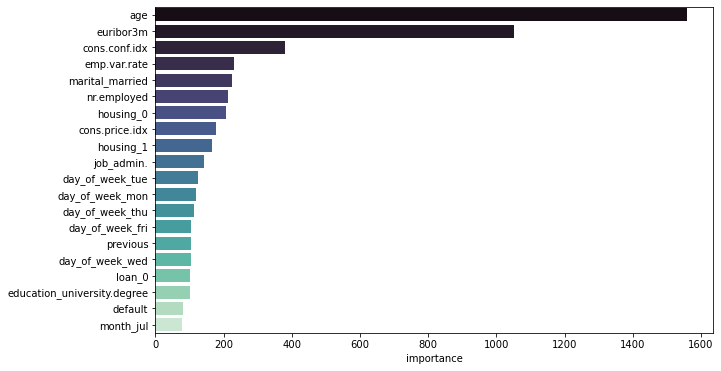

In [47]:
plt.figure(figsize=(10,6))
sns.barplot(df_feature_importance_excl.head(20).importance,
            df_feature_importance_excl.head(20).index, palette='mako');

## pdp

## SHAP

## LIME

## Estimate ATE, CATE

In [ ]:
# model= CausalModel(
#         data = training,
#         graph=causal_graph.replace("\n", " "),
#         treatment='High_limit',
#         outcome='Churn')
# model.view_model()
# display(Image(filename="causal_model.png"))